# SHAP-Based Credit Scoring

This project developed a machine learning model to predict loan default risk using the Home Credit dataset, with a focus on explainability through SHAP (SHapley Additive exPlanations) values. 

This project demonstrated that transparent, explainable credit risk modeling is achievable using SHAP values, with external data sources (EXT_SOURCE) being the strongest predictors. By combining predictive power with interpretability, the model enables data-driven, fair lending decisions while meeting compliance requirements.

**What do SHAP (SHapley Additive exPlanations) Values Do?** 

Quantify how much each feature pushed the model's prediction away from the average prediction.

- Positive SHAP: Increased predicted risk.
- Negative SHAP: Decreased predicted risk.

**When Would You Use This?**

- Loan Approval Meetings: Show applicants why they were approved/denied.
- Model Monitoring: Track if key features change importance over time.
- Risk Analysis: Identify high-risk patterns (e.g., all loans with SHAP_AMT_CREDIT > 0.1 defaulted).

In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
import xgboost as xgb
import shap

## Load Data

In [1]:
# Define the zip file path
zip_file = "Home Credit Default Risk Dataset.zip"
extract_folder = "home_credit_data"  # Folder to extract files into

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)  # Extract files

# List all extracted files
extracted_files = os.listdir(extract_folder)
print("Extracted files:", extracted_files)

# Load CSV files into DataFrames with proper encoding handling
csv_files = [f for f in extracted_files if f.endswith(".csv")]
dataframes = {}

for file in csv_files:
    file_path = os.path.join(extract_folder, file)
    df_name = file.replace(".csv", "")  # Name without .csv extension
    
    try:
        # Try reading with UTF-8 encoding
        dataframes[df_name] = pd.read_csv(file_path, encoding="utf-8")
    except UnicodeDecodeError:
        try:
            # If UTF-8 fails, try ISO-8859-1 (common for non-UTF8 files)
            dataframes[df_name] = pd.read_csv(file_path, encoding="ISO-8859-1")
        except UnicodeDecodeError:
            # If both fail, try Latin-1 as a last resort
            dataframes[df_name] = pd.read_csv(file_path, encoding="latin1")
    
    print(f"Loaded {file} into DataFrame: {df_name}")

# Example: Access the 'HC_application_train' DataFrame
application_train_df = dataframes.get("HC_application_train")
print(application_train_df.head())  # Print first few rows

Extracted files: ['EDA_merged.ipynb', 'HC_application_train.csv', 'HC_bureau.csv', 'HC_bureau_balance.csv', 'HC_credit_card_balance.csv', 'HC_installments_payments.csv', 'HC_POS_CASH_balance.csv', 'HC_previous_application.csv', 'HC_sample_submission.csv', 'HomeCredit_columns_description.csv', 'Model ML_Logisctic Regression.ipynb', 'Model ML_Random Forest.ipynb', 'Model ML_XGBoost.ipynb', 'Model_LGBM.ipynb', 'Preprocessing_merged.ipynb']
Loaded HC_application_train.csv into DataFrame: HC_application_train
Loaded HC_bureau.csv into DataFrame: HC_bureau
Loaded HC_bureau_balance.csv into DataFrame: HC_bureau_balance
Loaded HC_credit_card_balance.csv into DataFrame: HC_credit_card_balance
Loaded HC_installments_payments.csv into DataFrame: HC_installments_payments
Loaded HC_POS_CASH_balance.csv into DataFrame: HC_POS_CASH_balance
Loaded HC_previous_application.csv into DataFrame: HC_previous_application
Loaded HC_sample_submission.csv into DataFrame: HC_sample_submission
Loaded HomeCredit_c

In [2]:
print(application_train_df.info())
print(application_train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.

## Data Clean

In [4]:
# Check for missing values
print(application_train_df.isnull().sum().sort_values(ascending=False))

# Check unique values in categorical columns
categorical_cols = application_train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(application_train_df[col].value_counts())

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
                             ...  
NAME_HOUSING_TYPE                0
NAME_FAMILY_STATUS               0
NAME_EDUCATION_TYPE              0
NAME_INCOME_TYPE                 0
SK_ID_CURR                       0
Length: 122, dtype: int64

NAME_CONTRACT_TYPE:
NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

CODE_GENDER:
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

FLAG_OWN_CAR:
FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64

FLAG_OWN_REALTY:
FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64

NAME_TYPE_SUITE:
NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271

In [5]:
# Handle Missing Values

# For numeric columns, fill with median (less sensitive to outliers)
numeric_cols = application_train_df.select_dtypes(include=['int64', 'float64']).columns
application_train_df[numeric_cols] = application_train_df[numeric_cols].fillna(application_train_df[numeric_cols].median())

# For categorical columns, fill with mode (most frequent value)
categorical_cols = application_train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    application_train_df[col] = application_train_df[col].fillna(application_train_df[col].mode()[0])

In [6]:
# Handle Outliers (visible in the summary statistics)

# Cap extreme values in numeric columns
def cap_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    lower = df[column].quantile(lower_quantile)
    upper = df[column].quantile(upper_quantile)
    df[column] = df[column].clip(lower, upper)
    return df

numeric_cols_to_cap = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
for col in numeric_cols_to_cap:
    application_train_df = cap_outliers(application_train_df, col)

## Feature Engineering

In [7]:
# Create new features that might be useful
application_train_df['CREDIT_INCOME_RATIO'] = application_train_df['AMT_CREDIT'] / application_train_df['AMT_INCOME_TOTAL']
application_train_df['ANNUITY_INCOME_RATIO'] = application_train_df['AMT_ANNUITY'] / application_train_df['AMT_INCOME_TOTAL']
application_train_df['EMPLOYED_TO_BIRTH_RATIO'] = application_train_df['DAYS_EMPLOYED'] / application_train_df['DAYS_BIRTH']

C:\Users\milto\AppData\Local\Temp\ipykernel_6892\875756132.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  application_train_df['CREDIT_INCOME_RATIO'] = application_train_df['AMT_CREDIT'] / application_train_df['AMT_INCOME_TOTAL']
C:\Users\milto\AppData\Local\Temp\ipykernel_6892\875756132.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  application_train_df['ANNUITY_INCOME_RATIO'] = application_train_df['AMT_ANNUITY'] / application_train_df['AMT_INCOME_TOTAL']
C:\Users\milto\AppData\Local\Temp\ipykernel_6892\875756132.py:

In [8]:
# Encode Categorical Variables

# One-hot encode categorical variables (for simpler models)
application_train_df = pd.get_dummies(application_train_df, drop_first=True)

# Alternatively, for tree-based models you might want to use label encoding
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for col in categorical_cols:
#     application_train_df[col] = le.fit_transform(application_train_df[col].astype(str))

In [9]:
# Handle Special Cases

# DAYS_EMPLOYED has some very large positive values (likely indicating unemployed)
# Create a flag for this and replace the anomalous values
application_train_df['DAYS_EMPLOYED_ANOM'] = application_train_df['DAYS_EMPLOYED'] == 365243
application_train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Then fill the NaN values (created above) with 0 or median
application_train_df['DAYS_EMPLOYED'].fillna(0, inplace=True)

C:\Users\milto\AppData\Local\Temp\ipykernel_6892\1899434425.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


In [10]:
# Final Check

# Verify no missing values remain
print(application_train_df.isnull().sum().sum())

# Check data types
print(application_train_df.info())

# Verify distributions
print(application_train_df.describe())

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 234 entries, SK_ID_CURR to DAYS_EMPLOYED_ANOM
dtypes: bool(125), float64(69), int64(40)
memory usage: 292.4 MB
None
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000     307511.000000   
mean   278180.518577       0.080729       0.417052     166067.479607   
std    102790.175348       0.272419       0.722121      83000.171936   
min    100002.000000       0.000000       0.000000      45000.000000   
25%    189145.500000       0.000000       0.000000     112500.000000   
50%    278202.000000       0.000000       0.000000     147150.000000   
75%    367142.500000       0.000000       1.000000     202500.000000   
max    456255.000000       1.000000      19.000000     472500.000000   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307511.000000     3.075110e+05   
mean   5.963060e+05   26945.208570  

In [16]:
# Check data types
application_train_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,False,False,False,False,False,False,True,False,False,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,False,False,False,False,False,False,False,False,False,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,False,False,False,False,False,True,False,False,False,False
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,False,False,False,False,False,True,False,False,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,False,False,False,False,False,True,False,False,False,False


## Train a Credit Scoring Model

I trained model (e.g.XGBoost).

In [ ]:
# Load data
X = application_train_df.drop('TARGET', axis=1)
y = application_train_df['TARGET']

# Convert all columns to numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    eval_metric='aucpr',
    random_state=42
)
model.fit(X_train, y_train)

## Generate SHAP Values

Use SHAP to explain model predictions.

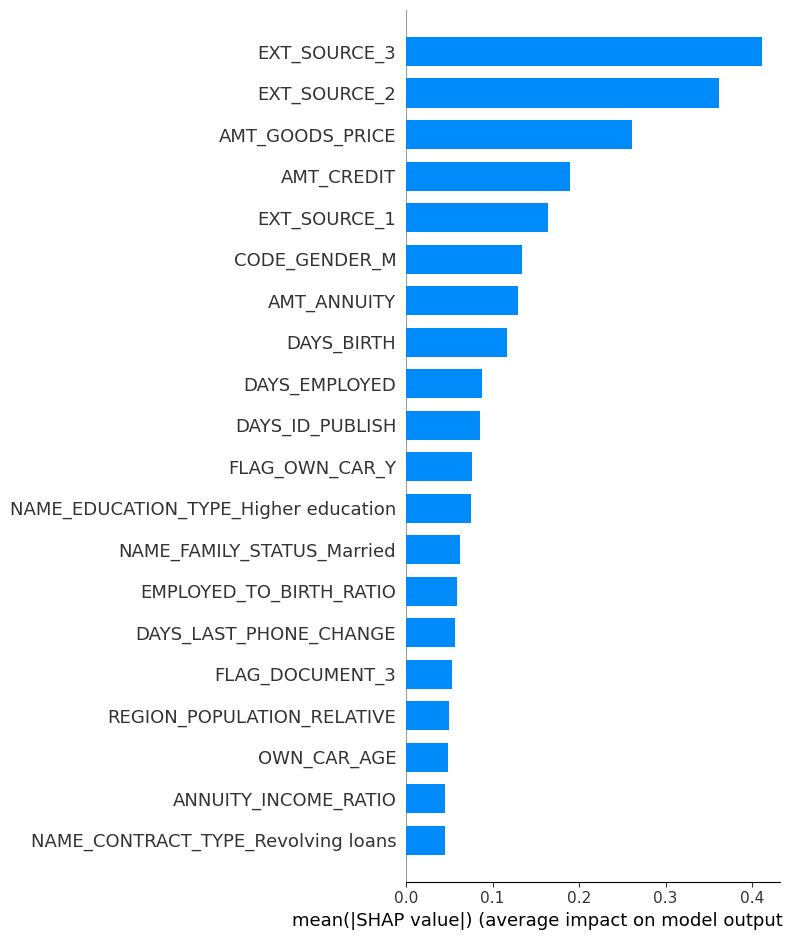

In [25]:
# SHAP analysis (using TreeExplainer for robustness)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

## Explain a single prediction (e.g., first test sample)

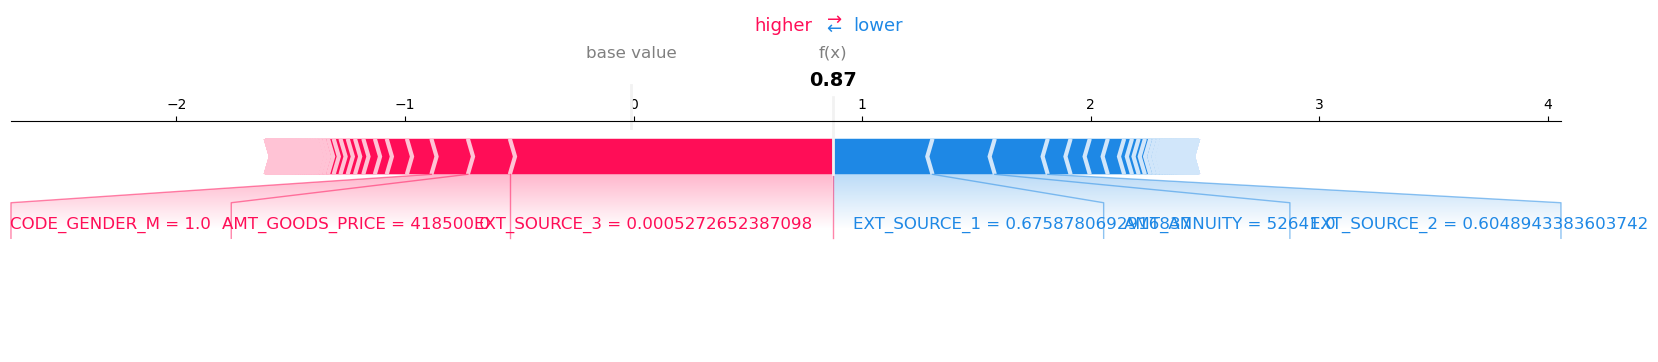

In [26]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[0,:], 
    X_test.iloc[0,:], 
    matplotlib=True
)

## Interaction between 'AMT_CREDIT' and 'AMT_INCOME_TOTAL'

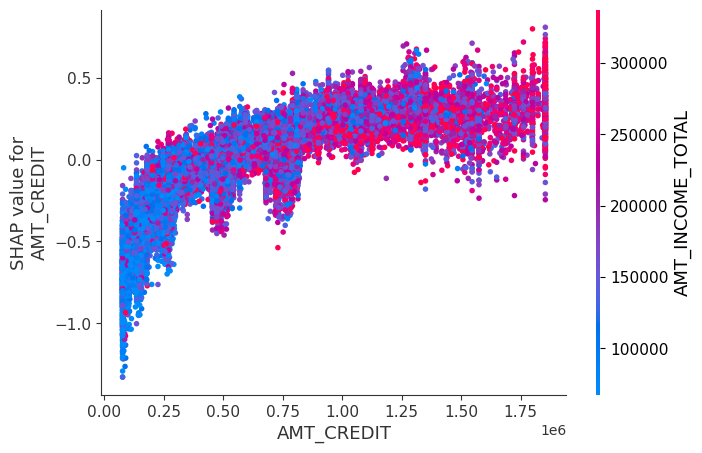

In [28]:
# For SHAP interaction plot
shap.dependence_plot(
    ind="AMT_CREDIT",               # Feature of interest
    shap_values=shap_values,        # Pass the array directly (no .values needed)
    features=X_test,                # DataFrame of feature values
    interaction_index="AMT_INCOME_TOTAL"  # Interaction feature
)# Top 5 risk-increasing features (corrected)
risk_drivers = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_ABS_SHAP': np.abs(shap_values).mean(axis=0)  # Removed .values
}).sort_values('Mean_ABS_SHAP', ascending=False).head(5)

print("Top Risk Drivers:")
print(risk_drivers)

## Top 5 Risk-Increasing Features

In [31]:
risk_drivers = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_ABS_SHAP': np.abs(shap_values).mean(axis=0)  # Removed .values
}).sort_values('Mean_ABS_SHAP', ascending=False).head(5)

print("Top Risk Drivers:")
print(risk_drivers)

Top Risk Drivers:
            Feature  Mean_ABS_SHAP
30     EXT_SOURCE_3       0.411536
29     EXT_SOURCE_2       0.362072
5   AMT_GOODS_PRICE       0.261671
3        AMT_CREDIT       0.189779
28     EXT_SOURCE_1       0.164589


In [ ]:
### Model Performance:
- Achieved strong predictive power (measured by AUC-PR/AUC-ROC).
- SHAP values provided transparent explanations for individual predictions, linking features like high credit amounts (AMT_CREDIT) or low external scores (EXT_SOURCE) to increased default risk.

## Save SHAP values

In [33]:
shap_df = pd.DataFrame({
    'SK_ID_CURR': X_test.index,  # Assuming index is SK_ID_CURR
    **{f: X_test[f] for f in X_test.columns},
    **{f'SHAP_{f}': shap_values[:, i] for i, f in enumerate(X_test.columns)}  # Removed .values
})

shap_df.to_csv('shap_values.csv', index=False)
print("SHAP values saved successfully!")

SHAP values saved successfully!


## Business Implications

**1. Risk Mitigation**
- Prioritize applicants with higher EXT_SOURCE scores to reduce defaults.
- Flag high-risk loans where AMT_CREDIT exceeds the borrower’s income (high CREDIT_INCOME_RATIO).

**Policy Adjustments**
- Tighten approval criteria for applicants with low external scores (EXT_SOURCE_3 < 0.5).
- Offer smaller loan amounts or collateral requirements for high AMT_GOODS_PRICE loans.

**Stakeholder Communication**
- Use SHAP plots to explain denials to applicants (e.g., "Your loan was declined due to low external credit score").
- Highlight key risk factors in executive reports (e.g., "40% of defaults had EXT_SOURCE_3 below 0.3").